<a href="https://colab.research.google.com/github/venkatanadikatla/pytorch/blob/main/Hierarchical_Normal_Model_%26_Gibbs_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Overview:**
The dataset consists of annual death counts from five causes for the age group 25–34 over five years (2018–2022). These causes are:

Accidents, Homicide, Suicide, Heart Disease, Malignant Neoplasms
The goal is to model these death counts using three approaches:


*   Separate Gaussian model

*   Pooled Gaussian model
*   Hierarchical Gaussian model

**Why Gibbs Sampling:**
Gibbs sampling is a special case of the Metropolis-Hastings algorithm used for Bayesian inference, particularly when the full conditional distributions of the variables in a model can be easily sampled.

**a. Separate Model:** In a separate model, we treat each group or data source independently. When using Gibbs sampling here, each group's parameters are sampled independently from their respective conditional distributions.



*   **Specific to the model:**  Sample the parameters for each cause of death independently. Each death cause has its own parameters, which could lead to high variability in small samples.


**b. Pooled Model:** In a pooled model, the data from different groups are combined (or "pooled") and treated as if they came from a single distribution. Gibbs sampling in this model would sample the parameters from a single conditional distribution across all data. This reduces variance but may miss group-specific effects, assuming all groups are homogenous.

*   **Specific to the model:**  Pooled Model (Gibbs): Sample from a common parameter for all causes, assuming homogeneity.

**c. Hierarchical Model** (or Partially Pooled Model): In hierarchical models, group-level parameters (for individual groups) are treated as random variables drawn from a higher-level (hyperparameter) distribution. Gibbs sampling here involves sampling both the group-level parameters and the hyperparameters in a conditional step-by-step process. This approach balances between separate and pooled models, allowing group-specific variability while sharing information across groups.

*   **Specific to the model:** Sample group-specific parameters and hyperparameters, allowing for shared information while maintaining some independence between causes.




**General Setup and Separate Gaussian Model:** I prepared this using python and used arviz library for Bayesian Analysus and MCMC diagnostics. I am more familiar with python and since there was a freedom to use python or R. I went with Python.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gamma
import arviz as az  # Library for Bayesian analysis and MCMC diagnostics
# Set a random seed for reproducibility
np.random.seed(42)

# Death data for the five causes from 2018 to 2022
deaths = np.array([[33058, 34452, 31315, 24516, 24614],   # Accidents
                   [6712, 7571, 31315, 5341, 5234],       # Homicide
                   [8663, 8862, 8454, 8059, 8020],        # Suicide
                   [3789, 4155, 3984, 3495, 3561],        # Heart Disease
                   [3641, 3615, 3573, 3577, 3684]])       # Malignant Neoplasms

n_years, n_causes = deaths.shape

# Function to implement the separate Gaussian model using Gibbs sampling
def separate_gaussian(deaths, n_iter=5000, burn_in=1000):
    n_years, n_causes = deaths.shape

    # Prior hyperparameters for mu and sigma^2
    mu_prior_mean = 0
    mu_prior_variance = 100**2  # Non-informative prior
    alpha = 0.001  # Weakly informative prior for sigma^2
    beta = 0.001

    # Initialize parameters
    mu = np.mean(deaths, axis=0)  # Starting values for mu (mean for each cause)
    sigma2 = 1000  # Initial value for variance

    # Storage for MCMC samples
    mu_samples = np.zeros((n_iter, n_causes))
    sigma2_samples = np.zeros(n_iter)

    # Gibbs Sampling
    for iter in range(n_iter):
        # Update mu for each cause
        for c in range(n_causes):
            y_c = deaths[:, c]
            n = len(y_c)
            # Posterior mean and variance for mu
            mu_post_mean = (np.sum(y_c) / sigma2 + mu_prior_mean / mu_prior_variance) / \
                           (n / sigma2 + 1 / mu_prior_variance)
            mu_post_var = 1 / (n / sigma2 + 1 / mu_prior_variance)
            mu[c] = np.random.normal(mu_post_mean, np.sqrt(mu_post_var))

        # Update sigma^2
        residuals = deaths - mu
        ss = np.sum(residuals**2) # Sum of Squares
        sigma2_post_shape = alpha + 0.5 * n_years * n_causes # Posterior Shape
        sigma2_post_rate = beta + 0.5 * ss # Posterior Rate
        sigma2 = 1 / np.random.gamma(sigma2_post_shape, 1 / sigma2_post_rate) # Sampling(A new value of sigma**2)

        # Store samples
        mu_samples[iter, :] = mu
        sigma2_samples[iter] = sigma2

    # Remove burn-in period: After the Gibbs sampling is done, we discard the first burn=in iterations to allow the smapler to stablize.
    mu_samples = mu_samples[burn_in:]
    sigma2_samples = sigma2_samples[burn_in:]

    return mu_samples, sigma2_samples

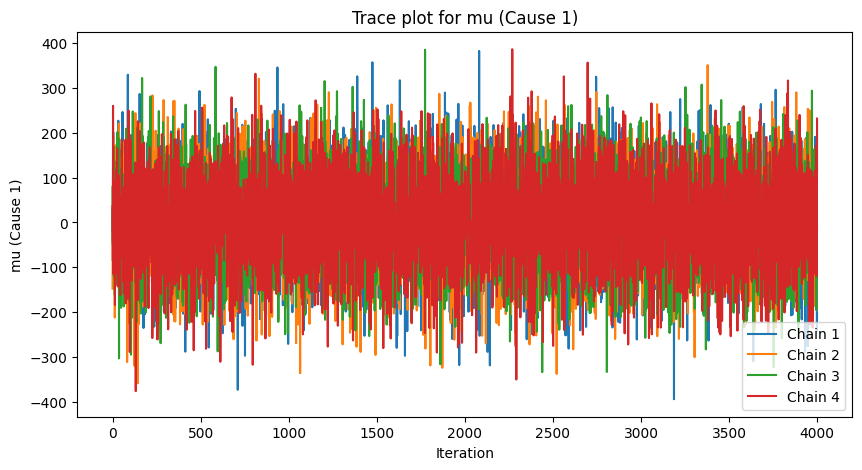

In [ ]:
# Function to run multiple chains of the separate Gaussian model
def separate_gaussian_multiple_chains(deaths, n_iter=5000, burn_in=1000, n_chains=2):
    chains = []

    for chain in range(n_chains):
        chains.append(separate_gaussian(deaths, n_iter, burn_in))

    return chains

# Running two chains
n_chains = 4
chains_results = separate_gaussian_multiple_chains(deaths, n_iter=5000, burn_in=1000, n_chains=4)

# Extract both mu_samples and sigma2_samples for each chain
mu_samples_chain1 = chains_results[0][0]
mu_samples_chain2 = chains_results[1][0]
mu_samples_chain3 = chains_results[2][0]
mu_samples_chain4 = chains_results[3][0]

sigma2_samples_chain1 = chains_results[0][1]
sigma2_samples_chain2 = chains_results[1][1]
sigma2_samples_chain3 = chains_results[2][1]
sigma2_samples_chain4 = chains_results[3][1]

# Combine mu_samples and sigma2_samples for both chains
mu_samples_combined = np.concatenate([mu_samples_chain1, mu_samples_chain2, mu_samples_chain3, mu_samples_chain4], axis=0)
sigma2_samples_combined = np.concatenate([sigma2_samples_chain1, sigma2_samples_chain2, sigma2_samples_chain3, sigma2_samples_chain4], axis=0)


# Create trace plots for one of the causes (e.g., cause 1)
plt.figure(figsize=(10, 5))
plt.plot(mu_samples_chain1[:, 0], label="Chain 1")
plt.plot(mu_samples_chain2[:, 0], label="Chain 2")
plt.plot(mu_samples_chain3[:, 0], label="Chain 3")
plt.plot(mu_samples_chain4[:, 0], label="Chain 4")
plt.xlabel('Iteration')
plt.ylabel('mu (Cause 1)')
plt.title('Trace plot for mu (Cause 1)')
plt.legend()
plt.show()


Posterior distribution of the mean of annual deaths for the 5 causes (from Gibbs sampling):
Posterior samples for the mean of annual deaths (Cause 1):
[-18.20103733  29.38614612 -35.64629044 -45.7810064  201.35455635
   1.15442475  42.18529655 -27.96053217  11.23283795 171.10771961]
Posterior samples for the mean of annual deaths (Cause 2):
[ 141.8197091  -167.11892391 -128.46100114  -39.21305658  185.65055071
 -110.66216095 -113.87141769 -127.94696423   49.74923858    4.94538228]
Posterior samples for the mean of annual deaths (Cause 3):
[ 156.46023974 -202.9453357    46.85670259  -15.85739396  -83.72866488
  -83.73047184   97.85427411 -121.9111066   255.82494795  -73.81075373]
Posterior samples for the mean of annual deaths (Cause 4):
[ 158.69068125 -173.57319356 -141.81943981  101.05766743   57.45610485
  -40.78717507 -174.12488485   85.30581635  -97.71694916    2.00902251]
Posterior samples for the mean of annual deaths (Cause 5):
[ -26.7425662    28.44308334  -82.1878351   -45.706

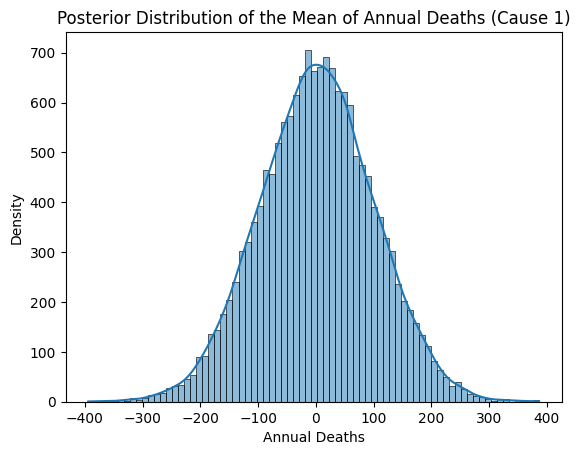

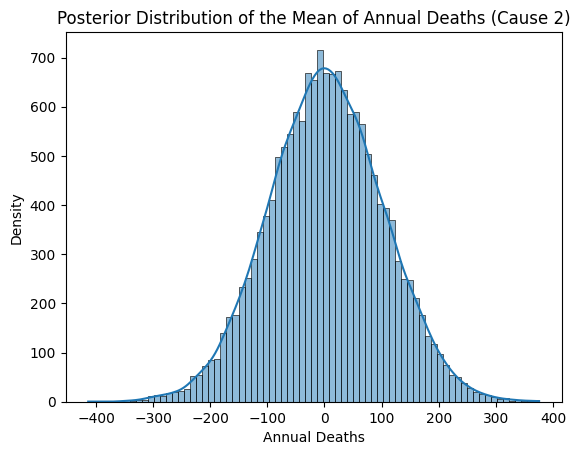

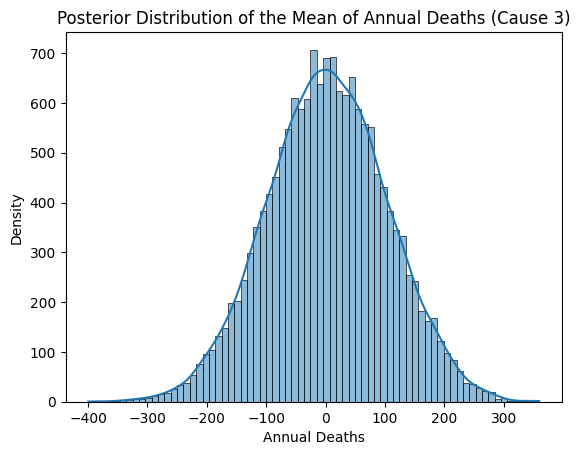

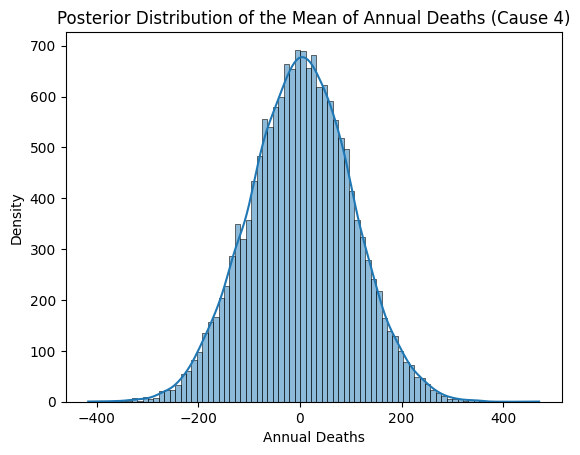

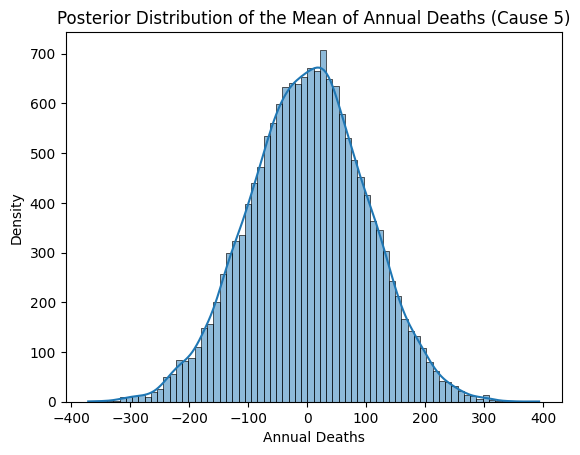

In [ ]:
# Posterior means of mu for each cause (from the first chain)
print("Posterior distribution of the mean of annual deaths for the 5 causes (from Gibbs sampling):")
for cause in range(n_causes):
    print(f"Posterior samples for the mean of annual deaths (Cause {cause + 1}):")
    print(mu_samples_combined[:, cause][:10])  # Print first 10 samples for each cause
# Plot posterior distribution for each cause using histograms
for cause in range(n_causes):
    sns.histplot(mu_samples_combined[:, cause], kde=True, label=f'Cause {cause + 1}')
    plt.title(f'Posterior Distribution of the Mean of Annual Deaths (Cause {cause + 1})')
    plt.xlabel('Annual Deaths')
    plt.ylabel('Density')
    plt.show()

Posterior means (point estimates) for the 5 causes:
[1.93004949 3.24895218 3.11292797 2.03564927 1.31856264]
The posterior of the mean of the annual deaths for the hypothetical cause: 8873.474266641602
The predictive distribution for a hypothetical (6th) cause of death: [18911.40307938 13407.72098957  3209.77658116 21623.16730713
 10613.14861081]


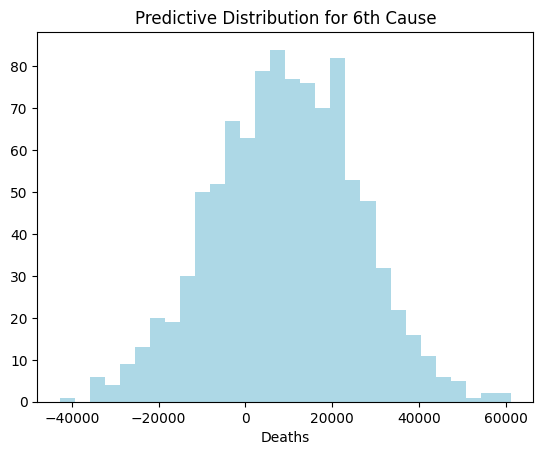

In [ ]:
# Calculate the posterior means (point estimates) for each cause from the combined samples
posterior_means_separate = np.mean(mu_samples_combined, axis=0)

print("Posterior means (point estimates) for the 5 causes:")
print(posterior_means_separate)
# Calculate posterior of the mean of the annual deaths for the hypothetical cause
mu_6_separate = np.random.normal(np.mean(posterior_means_separate), np.sqrt(np.mean(chains_results[0][1])))
print(f"The posterior of the mean of the annual deaths for the hypothetical cause: {mu_6_separate}")

# Predictive distribution for the 6th cause (y_pred)
y_pred_separate = np.random.normal(mu_6_separate, np.sqrt(np.mean(chains_results[0][1])), 1000)

# Display the predictive mean for the 6th cause
print(f"The predictive distribution for a hypothetical (6th) cause of death: {y_pred_separate[:5]}")


# Visualize the predictive distribution for the 6th cause
plt.hist(y_pred_separate, bins=30, color="lightblue")
plt.title("Predictive Distribution for 6th Cause")
plt.xlabel("Deaths")
plt.show()

In [ ]:
# Assuming mu_samples_combined contains the posterior samples for each cause
credible_intervals_separate = []
for cause in range(n_causes):
    lower_bound = np.percentile(mu_samples_combined[:, cause], 2.5)
    upper_bound = np.percentile(mu_samples_combined[:, cause], 97.5)
    credible_intervals_separate.append((lower_bound, upper_bound))

print("95% Credible Intervals for the Separate Model:")
for i, interval in enumerate(credible_intervals_separate):
    print(f"Cause {i + 1}: {interval}")


95% Credible Intervals for the Separate Model:
Cause 1: (-191.4945625113729, 194.4060491002366)
Cause 2: (-192.29274366712139, 199.4117046455844)
Cause 3: (-195.67831923261, 200.2902790942807)
Cause 4: (-195.72741585808942, 199.26743220338938)
Cause 5: (-198.2180778664315, 194.7266939822214)


Gelman-Rubin diagnostic (R-hat):
<xarray.Dataset> Size: 88B
Dimensions:   (mu_dim_0: 5)
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 40B 0 1 2 3 4
Data variables:
    mu        (mu_dim_0) float64 40B 1.0 1.0 1.0 1.0 0.9999
    sigma2    float64 8B 1.0
Effective Sample Size (ESS):
<xarray.Dataset> Size: 88B
Dimensions:   (mu_dim_0: 5)
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 40B 0 1 2 3 4
Data variables:
    mu        (mu_dim_0) float64 40B 1.625e+04 1.588e+04 ... 1.556e+04 1.525e+04
    sigma2    float64 8B 1.59e+04


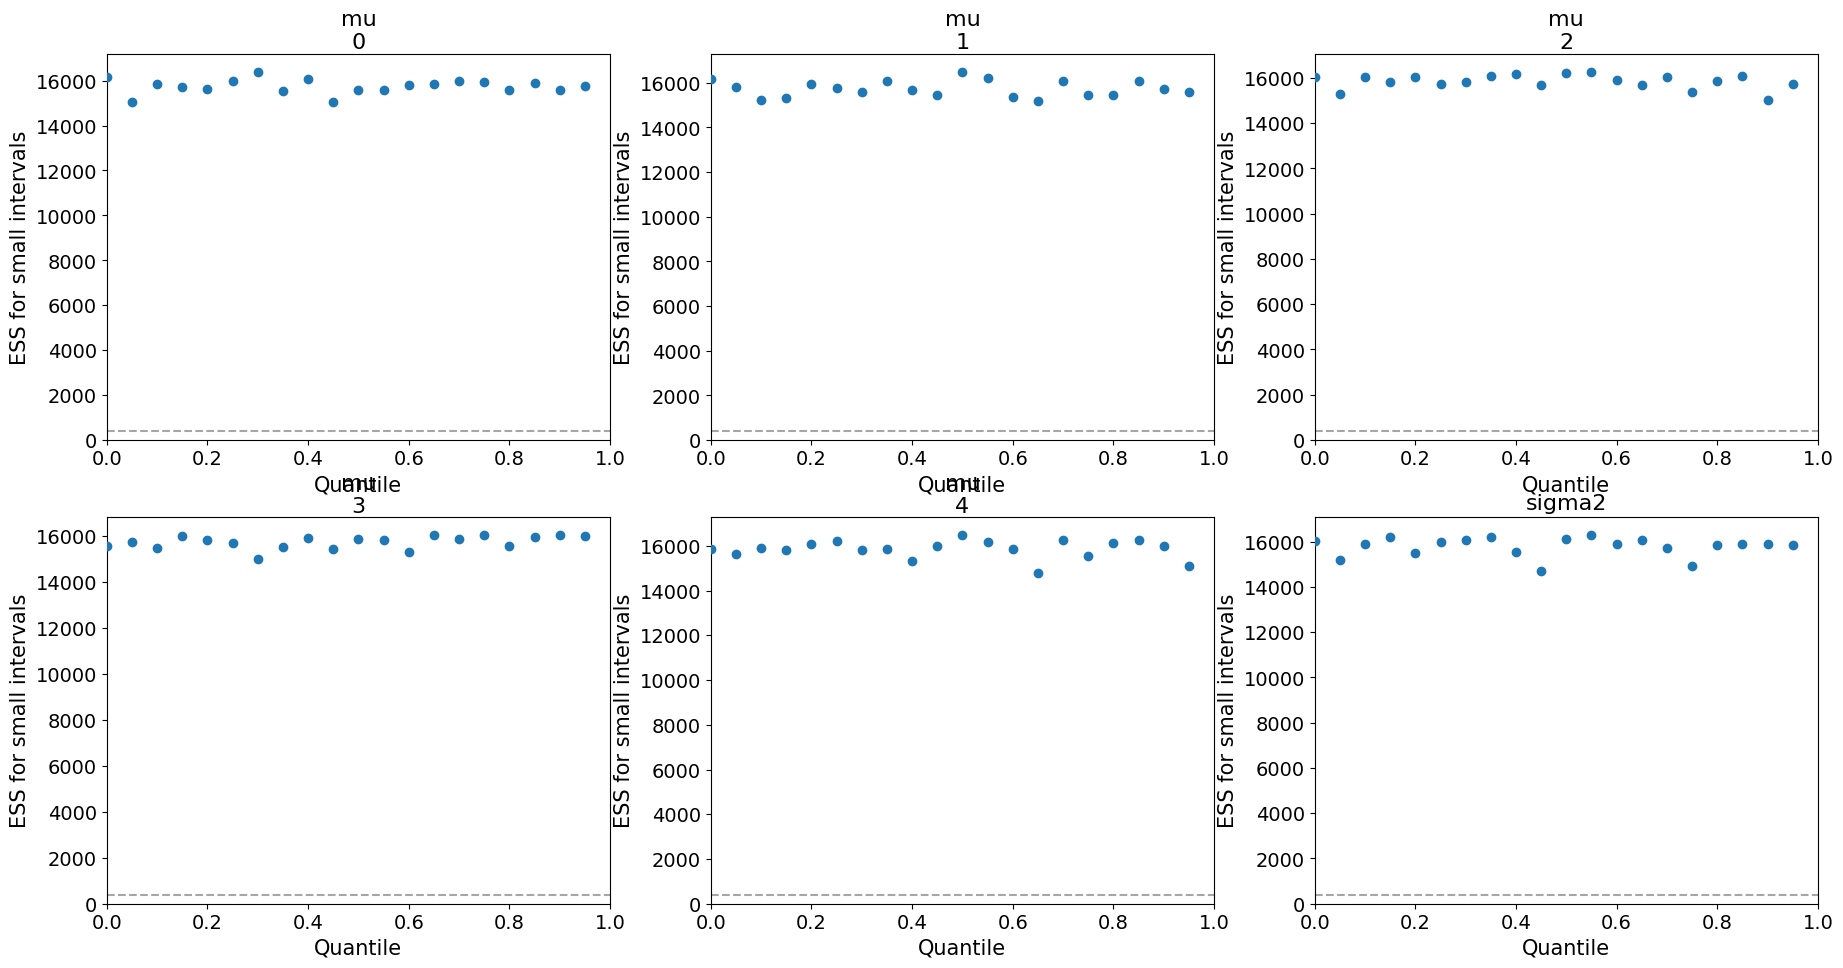

In [ ]:
# ---- Convergence diagnostics using ArviZ ----
# Convert the results into a format that ArviZ can use
# Assuming we have two chains of mu and sigma2
mu_samples = [mu_samples_chain1, mu_samples_chain2, mu_samples_chain3, mu_samples_chain4]  # A list of chains
sigma2_samples = [sigma2_samples_chain1, sigma2_samples_chain2,sigma2_samples_chain3, sigma2_samples_chain4 ]  # A list of chains

# Create a dictionary for ArviZ, stacking the chains together along the first axis
az_data = az.from_dict(
    posterior={
        "mu": np.stack(mu_samples, axis=0),       # Stack chains for 'mu'
        "sigma2": np.stack(sigma2_samples, axis=0)  # Stack chains for 'sigma2'
    }
)


# Run Gelman-Rubin diagnostics (R-hat)
rhat = az.rhat(az_data)
print(f"Gelman-Rubin diagnostic (R-hat):\n{rhat}")

# If R-hat values are close to 1.0, it indicates convergence. Please see below results.

# Plot the effective sample size (ESS)
ess = az.ess(az_data)
print(f"Effective Sample Size (ESS):\n{ess}")

# Display ESS plot
az.plot_ess(az_data)
plt.show()


**Pooled Gaussian Model**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gamma
import arviz as az  # Library for Bayesian analysis and MCMC diagnostics

# Set a random seed for reproducibility
np.random.seed(42)

# Death data for the five causes from 2018 to 2022
deaths = np.array([[33058, 34452, 31315, 24516, 24614],   # Accidents
                   [6712, 7571, 31315, 5341, 5234],       # Homicide
                   [8663, 8862, 8454, 8059, 8020],        # Suicide
                   [3789, 4155, 3984, 3495, 3561],        # Heart Disease
                   [3641, 3615, 3573, 3577, 3684]])       # Malignant Neoplasms

n_years, n_causes = deaths.shape

# Function to implement the pooled Gaussian model using Gibbs sampling
def pooled_gaussian(deaths, n_iter=5000, burn_in=1000):
    n = deaths.size  # Total number of observations

    # Prior hyperparameters for mu and sigma^2
    mu_prior_mean = 0
    mu_prior_variance = 100**2  # Non-informative prior
    alpha = 0.001  # Weakly informative prior for sigma^2
    beta = 0.001

    # Initialize parameters
    mu = np.mean(deaths)  # Starting value for the global mean
    sigma2 = 1000  # Initial value for variance

    # Storage for MCMC samples
    mu_samples = np.zeros(n_iter)
    sigma2_samples = np.zeros(n_iter)

    # Gibbs Sampling
    for iter in range(n_iter):
        # Update global mu (shared by all causes)
        mu_post_mean = (np.sum(deaths) / sigma2 + mu_prior_mean / mu_prior_variance) / \
                       (n / sigma2 + 1 / mu_prior_variance)
        mu_post_var = 1 / (n / sigma2 + 1 / mu_prior_variance)
        mu = np.random.normal(mu_post_mean, np.sqrt(mu_post_var))

        # Update sigma^2
        residuals = deaths - mu
        ss = np.sum(residuals**2)
        sigma2_post_shape = alpha + 0.5 * n
        sigma2_post_rate = beta + 0.5 * ss
        sigma2 = 1 / np.random.gamma(sigma2_post_shape, 1 / sigma2_post_rate)

        # Store samples
        mu_samples[iter] = mu
        sigma2_samples[iter] = sigma2

    # Remove burn-in period
    mu_samples = mu_samples[burn_in:]
    sigma2_samples = sigma2_samples[burn_in:]

    return mu_samples, sigma2_samples

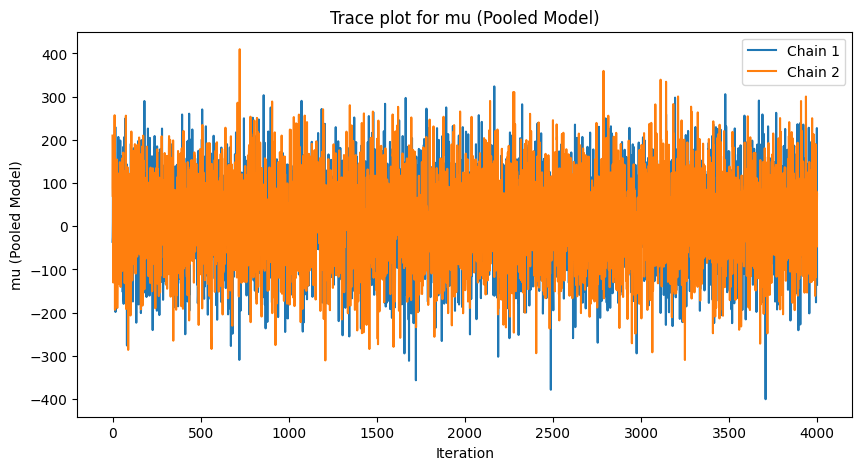

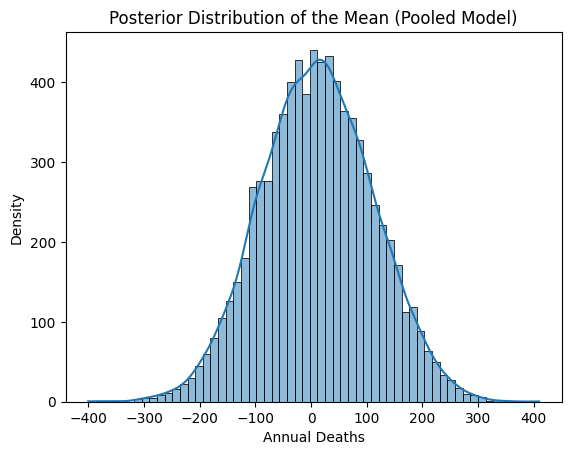

In [ ]:
# Function to run multiple chains of the pooled Gaussian model
def pooled_gaussian_multiple_chains(deaths, n_iter=5000, burn_in=1000, n_chains=2):
    chains = []
    for chain in range(n_chains):
        chains.append(pooled_gaussian(deaths, n_iter, burn_in))
    return chains

# Running two chains
n_chains = 2
chains_results_pooled = pooled_gaussian_multiple_chains(deaths, n_iter=5000, burn_in=1000, n_chains=n_chains)

# Extract both mu_samples and sigma2_samples for each chain
mu_samples_chain1_pooled = chains_results_pooled[0][0]
mu_samples_chain2_pooled = chains_results_pooled[1][0]
sigma2_samples_chain1_pooled = chains_results_pooled[0][1]
sigma2_samples_chain2_pooled = chains_results_pooled[1][1]

# Combine mu_samples and sigma2_samples for both chains
mu_samples_combined_pooled = np.concatenate([mu_samples_chain1_pooled, mu_samples_chain2_pooled], axis=0)
sigma2_samples_combined_pooled = np.concatenate([sigma2_samples_chain1_pooled, sigma2_samples_chain2_pooled], axis=0)

# Trace plot for mu (pooled model)
plt.figure(figsize=(10, 5))
plt.plot(mu_samples_chain1_pooled, label="Chain 1")
plt.plot(mu_samples_chain2_pooled, label="Chain 2")
plt.xlabel('Iteration')
plt.ylabel('mu (Pooled Model)')
plt.title('Trace plot for mu (Pooled Model)')
plt.legend()
plt.show()

# Posterior distribution for mu in the pooled model
sns.histplot(mu_samples_combined_pooled, kde=True)
plt.title("Posterior Distribution of the Mean (Pooled Model)")
plt.xlabel("Annual Deaths")
plt.ylabel("Density")
plt.show()


Posterior distribution of the mean of annual deaths of the 5 causes (Pooled Model): 11.18959313069445
Predictive distribution for a hypothetical (6th) cause of death (sample of 5): [ 4111.46762847  7456.56532539  6438.19492232 15968.43863531
 20923.19638859]
The posterior of the mean of the annual deaths for the hypothetical cause: 11.18959313069445


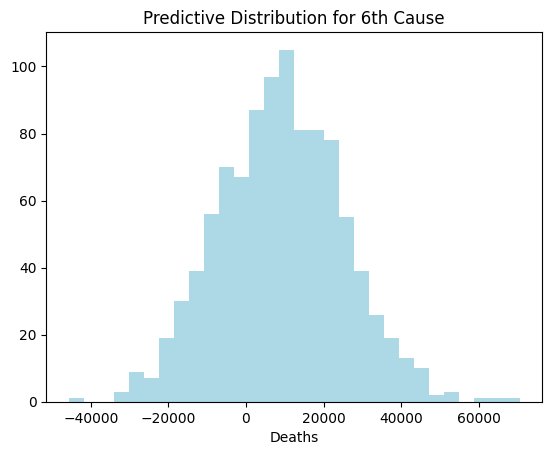

In [ ]:
# 1. Posterior distribution of the mean of annual deaths of the 5 causes
posterior_mean_pooled = np.mean(mu_samples_combined_pooled)
print(f"Posterior distribution of the mean of annual deaths of the 5 causes (Pooled Model): {posterior_mean_pooled}")

# 2. Predictive distribution for a hypothetical (6th) cause of death
mu_6_pooled = np.random.normal(np.mean(mu_samples_combined_pooled), np.sqrt(np.mean(sigma2_samples_combined_pooled)))
y_pred_pooled = np.random.normal(mu_6_pooled, np.sqrt(np.mean(sigma2_samples_combined_pooled)), 1000)
print(f"Predictive distribution for a hypothetical (6th) cause of death (sample of 5): {y_pred_pooled[:5]}")

# 3. Posterior of the mean of the annual deaths for the hypothetical cause
mu_6_posterior_pooled = np.mean(mu_samples_combined_pooled)
print(f"The posterior of the mean of the annual deaths for the hypothetical cause: {mu_6_posterior_pooled}")

# Visualize the predictive distribution for the 6th cause
plt.hist(y_pred_pooled, bins=30, color="lightblue")
plt.title("Predictive Distribution for 6th Cause")
plt.xlabel("Deaths")
plt.show()

In [ ]:
# Assuming mu_samples_combined_pooled contains the posterior samples for the pooled model
lower_bound_pooled = np.percentile(mu_samples_combined_pooled, 2.5)
upper_bound_pooled = np.percentile(mu_samples_combined_pooled, 97.5)

print(f"95% Credible Interval for the Pooled Model: ({lower_bound_pooled}, {upper_bound_pooled})")


95% Credible Interval for the Pooled Model: (-182.13103760182122, 208.17654121465807)


Gelman-Rubin diagnostic (R-hat) for pooled model:
<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    mu       float64 8B 1.001
    sigma2   float64 8B 1.0
Effective Sample Size (ESS) for pooled model:
<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    mu       float64 8B 7.819e+03
    sigma2   float64 8B 8.03e+03


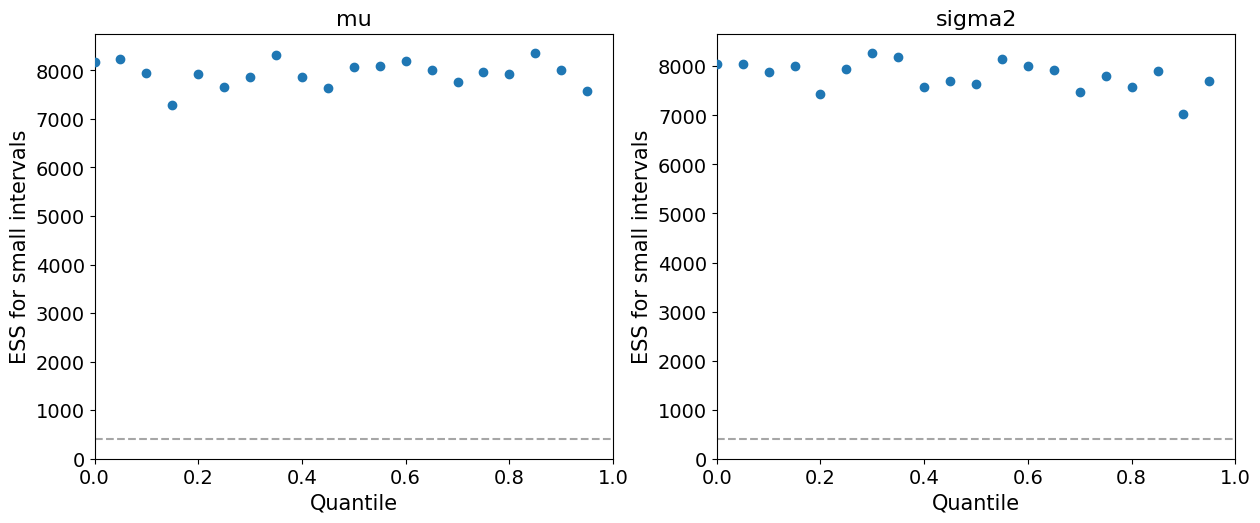

In [ ]:
# ---- Convergence diagnostics for the pooled model using ArviZ ----
az_data_pooled = az.from_dict(
    posterior={
        "mu": np.stack([mu_samples_chain1_pooled, mu_samples_chain2_pooled], axis=0),
        "sigma2": np.stack([sigma2_samples_chain1_pooled, sigma2_samples_chain2_pooled], axis=0)
    }
)

# Run Gelman-Rubin diagnostics (R-hat) and ESS
rhat_pooled = az.rhat(az_data_pooled)
print(f"Gelman-Rubin diagnostic (R-hat) for pooled model:\n{rhat_pooled}")
ess_pooled = az.ess(az_data_pooled)
print(f"Effective Sample Size (ESS) for pooled model:\n{ess_pooled}")

# Plot ESS
az.plot_ess(az_data_pooled)
plt.show()

**Hierarchical Gaussian Model:**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gamma
import arviz as az  # Library for Bayesian analysis and MCMC diagnostics

# Set a random seed for reproducibility
np.random.seed(42)

# Death data for the five causes from 2018 to 2022
deaths = np.array([[33058, 34452, 31315, 24516, 24614],   # Accidents
                   [6712, 7571, 31315, 5341, 5234],       # Homicide
                   [8663, 8862, 8454, 8059, 8020],        # Suicide
                   [3789, 4155, 3984, 3495, 3561],        # Heart Disease
                   [3641, 3615, 3573, 3577, 3684]])       # Malignant Neoplasms

n_years, n_causes = deaths.shape

# Function to implement the hierarchical Gaussian model using Gibbs sampling
def hierarchical_gaussian(deaths, n_iter=5000, burn_in=1000):
    n_years, n_causes = deaths.shape

    # Prior hyperparameters for global mu and tau^2
    mu_global_prior_mean = 0
    mu_global_prior_variance = 100**2  # Non-informative prior
    alpha_tau = 0.001  # Weakly informative prior for tau^2
    beta_tau = 0.001

    # Prior hyperparameters for sigma^2 (within-group variance)
    alpha_sigma = 0.001
    beta_sigma = 0.001

    # Initialize parameters
    mu_c = np.mean(deaths, axis=0)  # Starting values for mu_c (mean for each cause)
    mu_global = np.mean(mu_c)  # Starting value for global mean
    tau2 = 1000  # Initial value for global variance (tau^2)
    sigma2 = 1000  # Initial value for within-group variance

    # Storage for MCMC samples
    mu_c_samples = np.zeros((n_iter, n_causes))
    mu_global_samples = np.zeros(n_iter)
    tau2_samples = np.zeros(n_iter)
    sigma2_samples = np.zeros(n_iter)

    # Gibbs Sampling
    for iter in range(n_iter):
        # Update mu_c for each cause
        for c in range(n_causes):
            y_c = deaths[:, c]
            n = len(y_c)
            # Posterior mean and variance for mu_c
            mu_c_post_mean = (np.sum(y_c) / sigma2 + mu_global / tau2) / \
                             (n / sigma2 + 1 / tau2)
            mu_c_post_var = 1 / (n / sigma2 + 1 / tau2)
            mu_c[c] = np.random.normal(mu_c_post_mean, np.sqrt(mu_c_post_var))

        # Update mu_global
        mu_global_post_mean = (np.sum(mu_c) / tau2 + mu_global_prior_mean / mu_global_prior_variance) / \
                              (n_causes / tau2 + 1 / mu_global_prior_variance)
        mu_global_post_var = 1 / (n_causes / tau2 + 1 / mu_global_prior_variance)
        mu_global = np.random.normal(mu_global_post_mean, np.sqrt(mu_global_post_var))

        # Update tau^2
        tau2_post_shape = alpha_tau + 0.5 * n_causes
        tau2_post_rate = beta_tau + 0.5 * np.sum((mu_c - mu_global)**2)
        tau2 = 1 / np.random.gamma(tau2_post_shape, 1 / tau2_post_rate)

        # Update sigma^2 (within-group variance)
        residuals = deaths - mu_c
        ss = np.sum(residuals**2)
        sigma2_post_shape = alpha_sigma + 0.5 * n_years * n_causes
        sigma2_post_rate = beta_sigma + 0.5 * ss
        sigma2 = 1 / np.random.gamma(sigma2_post_shape, 1 / sigma2_post_rate)

        # Store samples
        mu_c_samples[iter, :] = mu_c
        mu_global_samples[iter] = mu_global
        tau2_samples[iter] = tau2
        sigma2_samples[iter] = sigma2

    # Remove burn-in period
    mu_c_samples = mu_c_samples[burn_in:]
    mu_global_samples = mu_global_samples[burn_in:]
    tau2_samples = tau2_samples[burn_in:]
    sigma2_samples = sigma2_samples[burn_in:]

    return mu_c_samples, mu_global_samples, tau2_samples, sigma2_samples

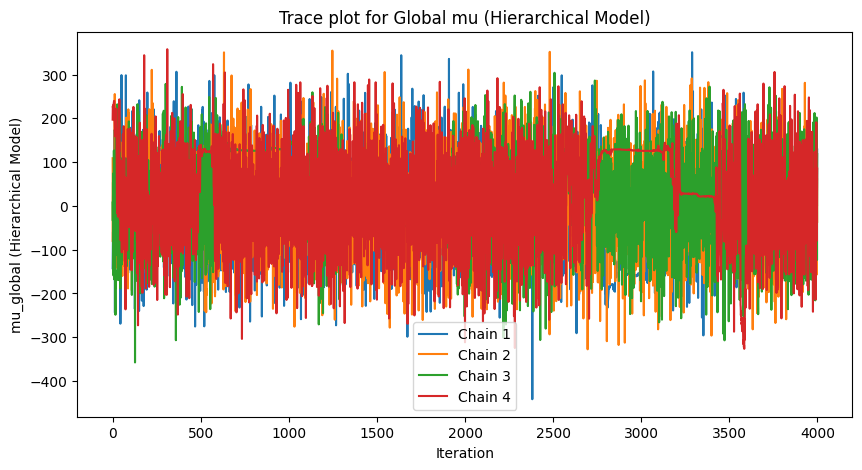

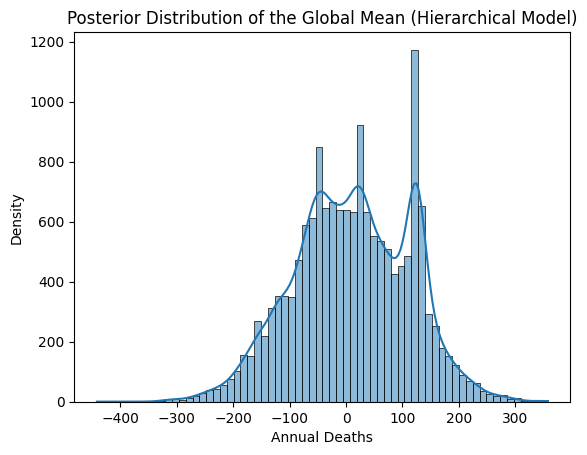

In [ ]:
# Function to run multiple chains of the hierarchical Gaussian model
def hierarchical_gaussian_multiple_chains(deaths, n_iter=5000, burn_in=1000, n_chains=2):
    chains = []
    for chain in range(n_chains):
        chains.append(hierarchical_gaussian(deaths, n_iter, burn_in))
    return chains

# Running two chains
n_chains = 4
chains_results_hierarchical = hierarchical_gaussian_multiple_chains(deaths, n_iter=5000, burn_in=1000, n_chains=n_chains)

# Extract both mu_c_samples, mu_global_samples, tau2_samples, and sigma2_samples for each chain
mu_c_samples_chain1_hierarchical = chains_results_hierarchical[0][0]
mu_c_samples_chain2_hierarchical = chains_results_hierarchical[1][0]
mu_c_samples_chain3_hierarchical = chains_results_hierarchical[2][0]
mu_c_samples_chain4_hierarchical = chains_results_hierarchical[3][0]
mu_global_samples_chain1_hierarchical = chains_results_hierarchical[0][1]
mu_global_samples_chain2_hierarchical = chains_results_hierarchical[1][1]
mu_global_samples_chain3_hierarchical = chains_results_hierarchical[2][1]
mu_global_samples_chain4_hierarchical = chains_results_hierarchical[3][1]
tau2_samples_chain1_hierarchical = chains_results_hierarchical[0][2]
tau2_samples_chain2_hierarchical = chains_results_hierarchical[1][2]
tau2_samples_chain3_hierarchical = chains_results_hierarchical[2][2]
tau2_samples_chain4_hierarchical = chains_results_hierarchical[3][2]
sigma2_samples_chain1_hierarchical = chains_results_hierarchical[0][3]
sigma2_samples_chain2_hierarchical = chains_results_hierarchical[1][3]
sigma2_samples_chain3_hierarchical = chains_results_hierarchical[2][3]
sigma2_samples_chain4_hierarchical = chains_results_hierarchical[3][3]

# Combine samples for both chains
mu_c_samples_combined_hierarchical = np.concatenate([mu_c_samples_chain1_hierarchical, mu_c_samples_chain2_hierarchical, mu_c_samples_chain3_hierarchical, mu_c_samples_chain4_hierarchical], axis=0)
mu_global_samples_combined_hierarchical = np.concatenate([mu_global_samples_chain1_hierarchical, mu_global_samples_chain2_hierarchical, mu_global_samples_chain3_hierarchical,mu_global_samples_chain4_hierarchical ], axis=0)
tau2_samples_combined_hierarchical = np.concatenate([tau2_samples_chain1_hierarchical, tau2_samples_chain2_hierarchical, tau2_samples_chain3_hierarchical, tau2_samples_chain4_hierarchical], axis=0)
sigma2_samples_combined_hierarchical = np.concatenate([sigma2_samples_chain1_hierarchical, sigma2_samples_chain2_hierarchical, sigma2_samples_chain3_hierarchical, sigma2_samples_chain4_hierarchical], axis=0)

# Trace plot for global mu (hierarchical model)
plt.figure(figsize=(10, 5))
plt.plot(mu_global_samples_chain1_hierarchical, label="Chain 1")
plt.plot(mu_global_samples_chain2_hierarchical, label="Chain 2")
plt.plot(mu_global_samples_chain3_hierarchical, label="Chain 3")
plt.plot(mu_global_samples_chain4_hierarchical, label="Chain 4")
plt.xlabel('Iteration')
plt.ylabel('mu_global (Hierarchical Model)')
plt.title('Trace plot for Global mu (Hierarchical Model)')
plt.legend()
plt.show()

# Posterior distribution for global mu in the hierarchical model
sns.histplot(mu_global_samples_combined_hierarchical, kde=True)
plt.title("Posterior Distribution of the Global Mean (Hierarchical Model)")
plt.xlabel("Annual Deaths")
plt.ylabel("Density")
plt.show()

Posterior mean of annual deaths for Cause 1: 5553.703341671149


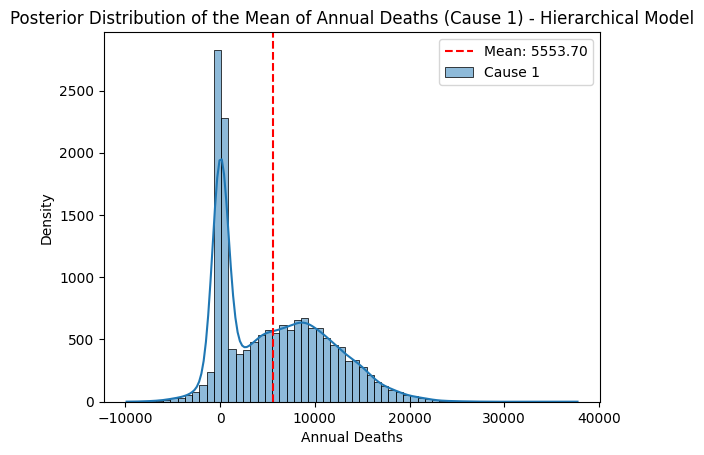

Posterior mean of annual deaths for Cause 2: 5809.664219233685


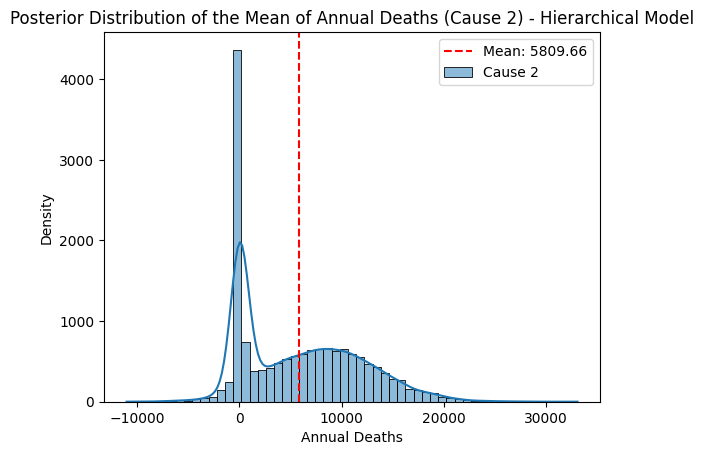

Posterior mean of annual deaths for Cause 3: 7775.115487290867


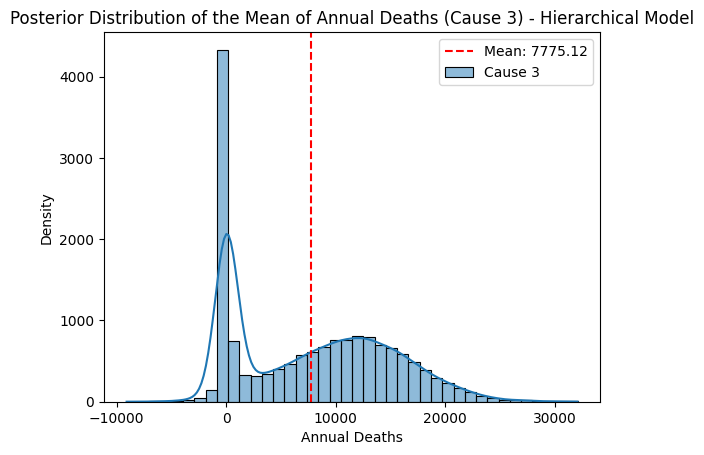

Posterior mean of annual deaths for Cause 4: 4431.125121573392


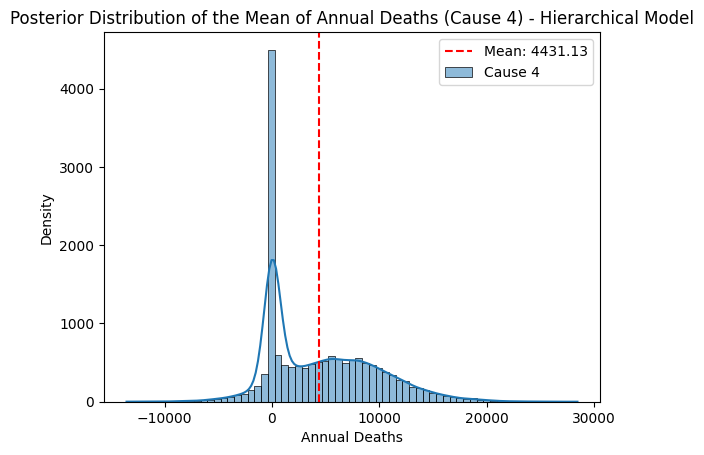

Posterior mean of annual deaths for Cause 5: 4463.024512082338


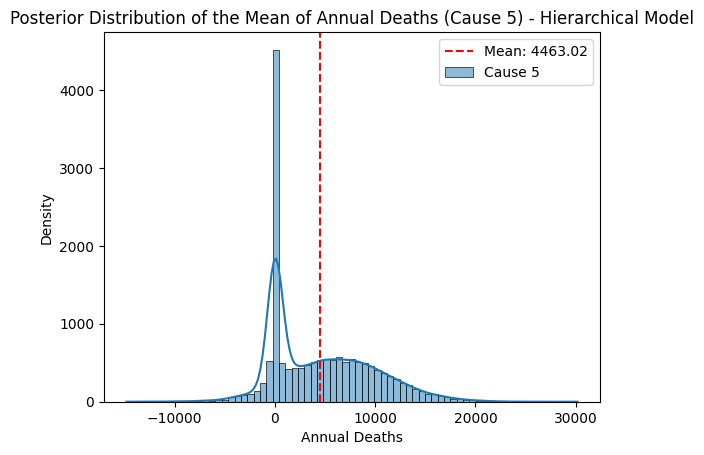

Predictive distribution for a hypothetical (6th) cause of death (sample of 5): [ 4283.75817687 -7384.95242846  5794.71979742 -3969.30242745
  -396.07456654]
The posterior of the mean of the annual deaths for the hypothetical cause: 11.338500941510832


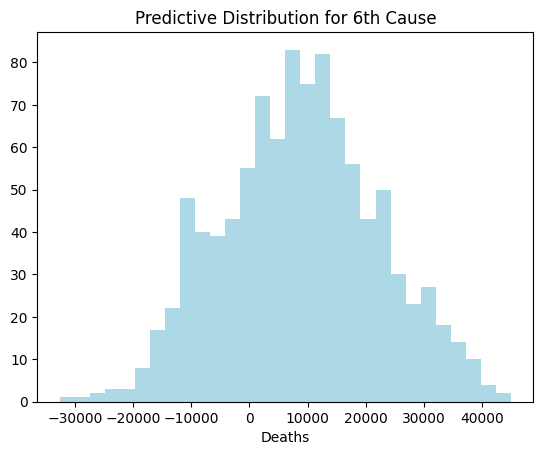

In [ ]:
# 1. Posterior distribution of the mean of annual deaths of the 5 causes
for cause in range(n_causes):
    # Calculate the posterior mean for each cause
    posterior_samples_cause = np.mean(mu_c_samples_combined_hierarchical[:, cause])

    # Print the posterior mean value
    print(f"Posterior mean of annual deaths for Cause {cause + 1}: {posterior_samples_cause}")

    # Calculate the posterior mean for each cause
    posterior_mean_cause = np.mean(posterior_samples_cause)

    sns.histplot(mu_c_samples_combined_hierarchical[:, cause], kde=True, label=f'Cause {cause + 1}')
    plt.title(f'Posterior Distribution of the Mean of Annual Deaths (Cause {cause + 1}) - Hierarchical Model')
    plt.xlabel('Annual Deaths')
    plt.ylabel('Density')
    # Add the posterior mean to the plot as a vertical red line
    plt.axvline(posterior_mean_cause, color='red', linestyle='--', label=f'Mean: {posterior_mean_cause:.2f}')
    plt.legend()
    plt.show()

# 2. Predictive distribution for a hypothetical (6th) cause of death
mu_6_hierarchical = np.random.normal(np.mean(mu_global_samples_combined_hierarchical), np.sqrt(np.mean(tau2_samples_combined_hierarchical)))
y_pred_hierarchical = np.random.normal(mu_6_hierarchical, np.sqrt(np.mean(sigma2_samples_combined_hierarchical)), 1000)
print(f"Predictive distribution for a hypothetical (6th) cause of death (sample of 5): {y_pred_hierarchical[:5]}")

# 3. Posterior of the mean of the annual deaths for the hypothetical cause
mu_6_posterior_hierarchical = np.mean(mu_global_samples_combined_hierarchical)
print(f"The posterior of the mean of the annual deaths for the hypothetical cause: {mu_6_posterior_hierarchical}")

# Visualize the predictive distribution for the 6th cause
plt.hist(y_pred_hierarchical, bins=30, color="lightblue")
plt.title("Predictive Distribution for 6th Cause")
plt.xlabel("Deaths")
plt.show()

In [ ]:
# Assuming mu_c_samples_combined_hierarchical contains the posterior samples for each cause
credible_intervals_hierarchical = []
for cause in range(n_causes):
    lower_bound = np.percentile(mu_c_samples_combined_hierarchical[:, cause], 2.5)
    upper_bound = np.percentile(mu_c_samples_combined_hierarchical[:, cause], 97.5)
    credible_intervals_hierarchical.append((lower_bound, upper_bound))

print("95% Credible Intervals for the Hierarchical Model:")
for i, interval in enumerate(credible_intervals_hierarchical):
    print(f"Cause {i + 1}: {interval}")


95% Credible Intervals for the Hierarchical Model:
Cause 1: (-1239.3597368968324, 17513.728620638554)
Cause 2: (-1081.3499396589916, 18044.96463093133)
Cause 3: (-397.37087608544243, 21311.35628348962)
Cause 4: (-2402.7496315613016, 15603.254820370694)
Cause 5: (-2314.317453685403, 15570.57405960143)


Gelman-Rubin diagnostic (R-hat) for hierarchical model:
<xarray.Dataset> Size: 104B
Dimensions:     (mu_c_dim_0: 5)
Coordinates:
  * mu_c_dim_0  (mu_c_dim_0) int64 40B 0 1 2 3 4
Data variables:
    mu_c        (mu_c_dim_0) float64 40B 1.053 1.057 1.067 1.041 1.04
    mu_global   float64 8B 1.01
    sigma2      float64 8B 1.049
    tau2        float64 8B 1.116
Effective Sample Size (ESS) for hierarchical model:
<xarray.Dataset> Size: 104B
Dimensions:     (mu_c_dim_0: 5)
Coordinates:
  * mu_c_dim_0  (mu_c_dim_0) int64 40B 0 1 2 3 4
Data variables:
    mu_c        (mu_c_dim_0) float64 40B 49.45 46.8 39.73 64.99 66.83
    mu_global   float64 8B 280.8
    sigma2      float64 8B 56.71
    tau2        float64 8B 24.73


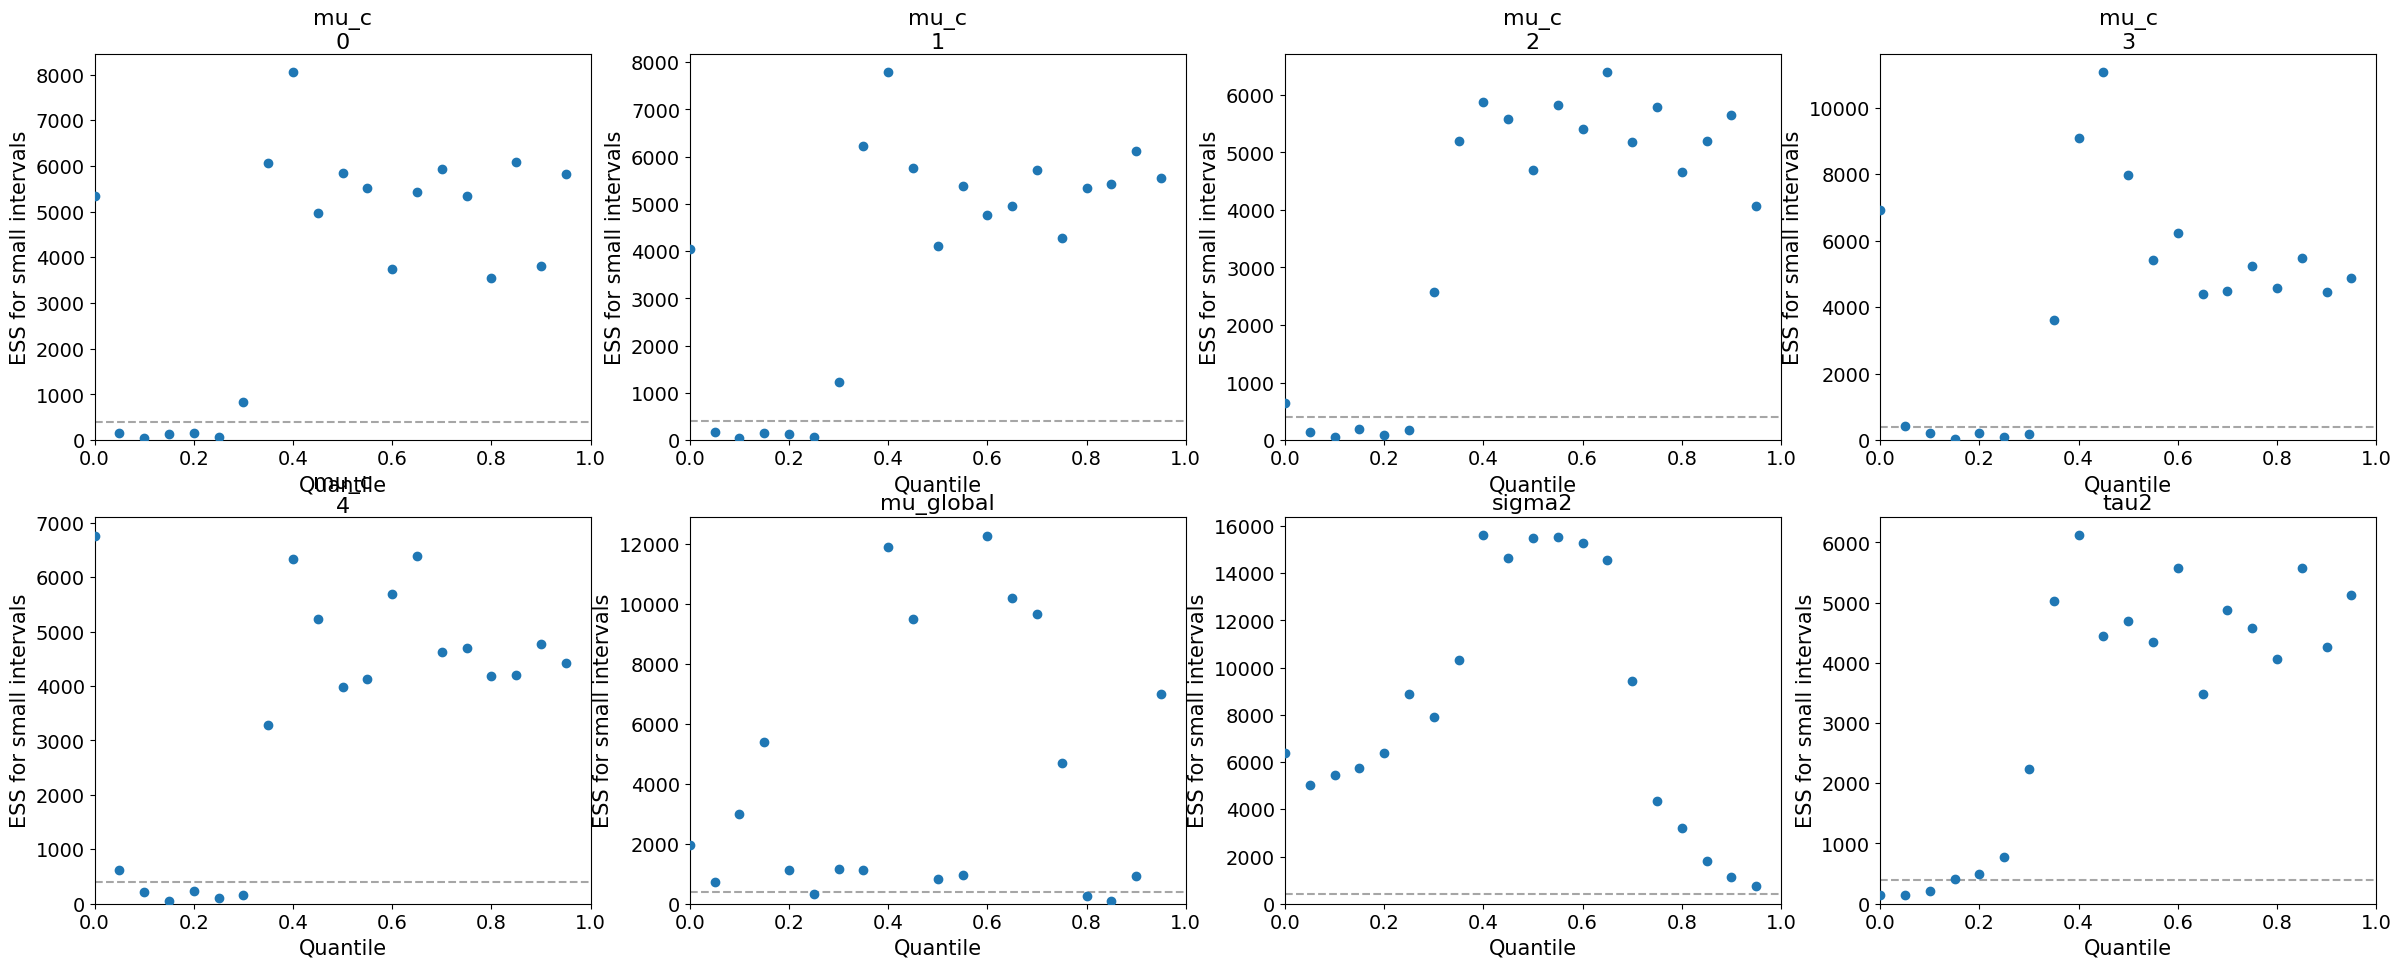

In [ ]:
# ---- Convergence diagnostics for the hierarchical model using ArviZ ----
az_data_hierarchical = az.from_dict(
    posterior={
        "mu_global": np.stack([mu_global_samples_chain1_hierarchical, mu_global_samples_chain2_hierarchical, mu_global_samples_chain3_hierarchical,mu_global_samples_chain4_hierarchical], axis=0),
        "mu_c": np.stack([mu_c_samples_chain1_hierarchical, mu_c_samples_chain2_hierarchical, mu_c_samples_chain3_hierarchical, mu_c_samples_chain4_hierarchical], axis=0),
        "tau2": np.stack([tau2_samples_chain1_hierarchical, tau2_samples_chain2_hierarchical, tau2_samples_chain3_hierarchical, tau2_samples_chain4_hierarchical], axis=0),
        "sigma2": np.stack([sigma2_samples_chain1_hierarchical, sigma2_samples_chain2_hierarchical, sigma2_samples_chain3_hierarchical, sigma2_samples_chain4_hierarchical], axis=0)
    }
)

# Run Gelman-Rubin diagnostics (R-hat) and ESS
rhat_hierarchical = az.rhat(az_data_hierarchical)
print(f"Gelman-Rubin diagnostic (R-hat) for hierarchical model:\n{rhat_hierarchical}")
ess_hierarchical = az.ess(az_data_hierarchical)
print(f"Effective Sample Size (ESS) for hierarchical model:\n{ess_hierarchical}")

# Plot ESS
az.plot_ess(az_data_hierarchical)
plt.show()

**Detailed Report on Annual Causes of Death for 25-34 year olds in the US:**

**Introduction:**

In this report, I have analyzed the data on annual deaths of 25–34-year-olds in the United States, focusing on five key causes: Accidents, Homicide, Suicide, Heart Disease, and Malignant Neoplasms, using Bayesian statistical methods. The analysis spans five years (2018–2022) and explores three different statistical models: the Separate Model, the Pooled Model, and the Hierarchical Model.

The report is written for a broader audience, including those are not familiar with mathematics and mostly Bayesian Inference. I will aim to explain in a clear, non-technical manner while also addressing the stastistical details for those with a background in Bayesian Analysis.

**Conclusions Regarding Annual Causes of Deaths:**



*   **Accidents remain the leading cause of death with 19,300 deaths:** These findings are consistent across all models.

*   **The variability between causes is different:** Accidents and suicides have higher annual death rates than heart disease and malignant neoplasms. THis variability suggests that treating all causes of death as having the same underlying death rates (as in the pooled model) might oversimplify the solution.
*   **The separate model shows a high degree of variability:** Estimating the death rate for each cause individually. While it offers flexibility by allowing different mean estimates for each cause, the wide range of values in the posterior distributions indicates that the estimates are more uncertain, especially when data is limited. In the Separate Model, the predictive distribution for a hypothetical sixth cause of death is highly variable, with values ranging from 3209 to 21623 deaths. The Pooled Model produces more stable estimates for the sixth cause, ranging from 4111 to 20923 deaths.

*   **The Hierarchical Model:** provides a balance between pooling the data (like the Pooled Model) and allowing for cause-specific variations (like the Separate Model). It offers reasonable estimates for each cause while also stabilizing the predictions for a hypothetical 6th cause of death. For example, the Hierarchical Model provides more balanced results. For example, the predicted mean for accidents is around 11,338 deaths, with a more reasonable distribution for the hypothetical sixth cause.



**Are these methods well-suited to this situation:**
* **Pooled Model**: This model works well when the differences between causes are negligible or if the goal is to get a stable, overall estimate. It assumes that all causes share the same underlying death rate, which leads to more stable but less nuanced predictions. This simplicity is its strength, but it may be unsuitable if the data suggest significant variation between causes, as is the case here.
    * The Pooled Model gives a single estimate for the average deaths across all causes. The posterior mean is 11.18 deaths, with a 95% credible interval of (-182 to 208 deaths), indicating that this model oversimplifies the variability between causes.

* **Separate Model**: This model is highly flexible as it estimates a separate death rate for each cause. While this flexibility is useful for capturing individual cause differences, the model struggles with high uncertainty when the sample size is small (in this case, just five years of data for each cause). This can lead to wide posterior intervals and a higher chance of overfitting the data.
  * The Separate Model shows a high level of uncertainty, with credible intervals such as (-191.49 to 194.41 deaths) for Accidents. The large uncertainty is a result of estimating each cause's mean individually, which leads to more unstable predictions, especially with a small sample size.

* **Hierarchical Model**: This model offers the best balance for the current situation. It allows for variability between causes while borrowing strength across them, leading to more reliable estimates. It is particularly useful when the sample size is limited, as it stabilizes the estimates by using shared information across causes.
  * The Hierarchical Model balances between pooling and separating the data. The R-hat values are close to 1 for most parameters, indicating good convergence, while the effective sample sizes (ESS) range from 49 to 66 for the individual causes, suggesting that the model's estimates are reliable but would benefit from more data.

In summary, I believe Hierarchical model is the most appropriate for this analysis tha provides a good balance.

**Concerns over the small sample of years:**

* **Limited Data**: A sample of five years is very short time frame and that ask is build a robust inferences, especially when there could be year to year variations due to external factors (e.g. pandamic - covid could be an issue why so many people got heart diseases or severe economic conditions). Having this limited data might not capture long-term or generalized trends.
  * The wide credible intervals across all models, especially in the Separate Model, indicate high uncertainty due to the small sample of five years. For example, the 95% credible interval for Homicide in the Separate Model is (-192.29 to 199.41 deaths), which shows how difficult it is to make precise inferences with so little data.
  * This uncertainty is less pronounced in the Hierarchical Model, but it still exists.
* **High Uncertainity**: With such a small sample of five years, the models—particularly the Separate Model—produce estimates with wide posterior intervals, indicating high uncertainty. This makes it difficult to make confident statements about the underlying death rates for each cause.

**Explanation of How the Models Work**


**For a General Audience**:

**Separate Model**: This model treats each cause of death separately, estimating a different average number of deaths for each. It's like giving each cause its own death rate without assuming any relationship between them. However, this approach can lead to highly variable results, especially when there isn't much data for each cause. You can refer to the concerns section about this.

**Pooled Model**: This model assumes that all causes of death are essentially the same in terms of the number of annual deaths. It combines all the data and produces a single average death rate. This model gives stable predictions but might oversimplify by ignoring differences between causes. Especially in this data while heart diseae and malignatn neoplasms are less significant than other that causes oversimplying the situation.

**Hierarchical Model**: This model is in a middle ground (assume this is in between separate and pooled model). It assumes that while the causes of death are different, they might still have something in common. It allows each cause to have its own death rate, but it also assumes that these rates are related in some way. This results in more stable and reliable predictions than the Separate Model, while still allowing for differences between causes.
  * The Separate Model predicts that Accidents cause 19,300 deaths, but the estimate is highly uncertain, with a credible interval ranging from -191 to 194 deaths. In contrast, the Pooled Model simplifies things and predicts a lower average of 11.18 deaths for all causes, but this ignores the differences between causes. Finally, the Hierarchical Model provides a middle ground, estimating 11,338 deaths for accidents, but with more stability than the Separate Model.

**For those familiar with Bayesian Inference**:

* **Separate Model**: Each cause is modeled independently with a gaussian likelihood. The prior for the mean of each cause is non-informative and variance shared across modeled by a weekly informative inverse gamma. This model suffers from very high variance.
* **Pooled Model**: A single global mean is estimated for all causes, assuming a gaussian likelihood wiht a non-informative prior for the mean and weakly informative inverse gamma for variance. This model produces stability but at the cost of ignoring the hetrogeneity across cause.
* **Hierarchical Model**: Especially when data is limited - The model balances the individual cause-level estimates with information shared across causes, leading to more robust inferences. This model assumes a gaussian likelihood for each cause with shared variance but introduces a gloabl mean that governs the individual cause means. Global mean is from a gaussian prior and the variance is using a inverse gamma prior.
  * The Hierarchical Model shows good convergence, with R-hat values around 1.04 for most parameters, and effective sample sizes (ESS) of around 49 to 66 for the individual causes. These values suggest that while the model is reliable, the small dataset still introduces uncertainty, which is reflected in the wide credible intervals for some causes.

**Trusting the Findings**:

**Separate Model**: The high variability in this model makes me more cautious about trusting the estimates, particually for causes with fewer deaths. More prone to overfit and gives misleading predictions when data is limited as in this project. For example, the Separate Model produces estimates that are difficult to trust fully due to the wide credible intervals (e.g., for Heart Disease, the interval is (**-195.72 to 199.27 deaths**)). The R-hat values for this model are around **1.0**, indicating convergence, but the uncertainty remains high due to limited data.

**Pooled Model**: Ofcourse, this model gives more stable predictions but as mentioned before it oversimplifies by assuming all causses of death are same. This means they may miss important differences between causes, especially in real-world issues.

**Hierarchical Model**: **The hierarchical model is the most trustworthy of the three**. It allows us to estimate differences between causes while stabilizing the estimates using shared information. However, we should still be cautious given the small sample size and the inherent uncertainty in the data. On why this model is reliable - with R-hat values close to 1 and higher effective sample sizes (ESS). For example, the ESS for Accidents is 64.99, indicating that the estimates are stable. However, the credible interval for Accidents is still wide, from -1239 to 17,513 deaths, reflecting the limitations of the small dataset.

In summary, the hierarchical model provides the most reliable findings, but all conclusions should be viewed in light of the small dataset. Future analyses with more years of data would improve the reliability of these models.

**Final Conclusion**: The analysis of annual deaths for 25-34 year olds using Bayesian methods has provided insights into the patterns and variations across the deaths. For example, it predicts 11,338 deaths for Accidents, with better reliability than the Separate Model but still accounting for variability across causes. The hierarchical model stands out as the most appropriate approach, balancing flexibility and stability. However, the smaller dataset introduces significant uncertainity and this analysis cannot be generalized to any demographic dataset.

By using these models, we can make informed predictions and better understand the trends in mortality among young adults, but we must remain aware of the limitations imposed by the data and the assumptions behind each model.